# RB1 and MCM

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re

import cptac
import cptac.utils as u

In [53]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [2]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Endometrial()
desired_cutoff = 0.05
gene = 'RB1'

# Proteomics

In [3]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
omics_gene_list = ['MCM2','MCM3','MCM6']
prot_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = omics_gene_list) # single col level

# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['RB1_mutation_status'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_prot = mut_wt.drop(columns_to_drop, axis = 1)

In [49]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
prot_col_list = list(binary_prot.columns).remove('RB1_mutation_status')

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
prot_pval_results = u.wrap_ttest(binary_prot, 'RB1_mutation_status', prot_col_list,verbose=True)
prot_pval_results

Doing t-test comparison for mutation status
MCM2_proteomics :  0.22802365369751898
MCM3_proteomics :  0.07349230243509774
MCM6_proteomics :  0.08586379496655382
No significant comparisons.


In [5]:
binary_prot_melted = binary_prot.melt(id_vars='RB1_mutation_status')
binary_prot_melted

,RB1_mutation_status,Name,value
0,Wildtype,MCM2_proteomics,0.6150
1,Wildtype,MCM2_proteomics,0.9100
2,Wildtype,MCM2_proteomics,-0.0715
3,Wildtype,MCM2_proteomics,-0.5630
4,Wildtype,MCM2_proteomics,1.4100
...,...,...,...
280,Wildtype,MCM6_proteomics,0.6860
281,Wildtype,MCM6_proteomics,0.3380
282,Wildtype,MCM6_proteomics,0.9230
283,Wildtype,MCM6_proteomics,-0.4010


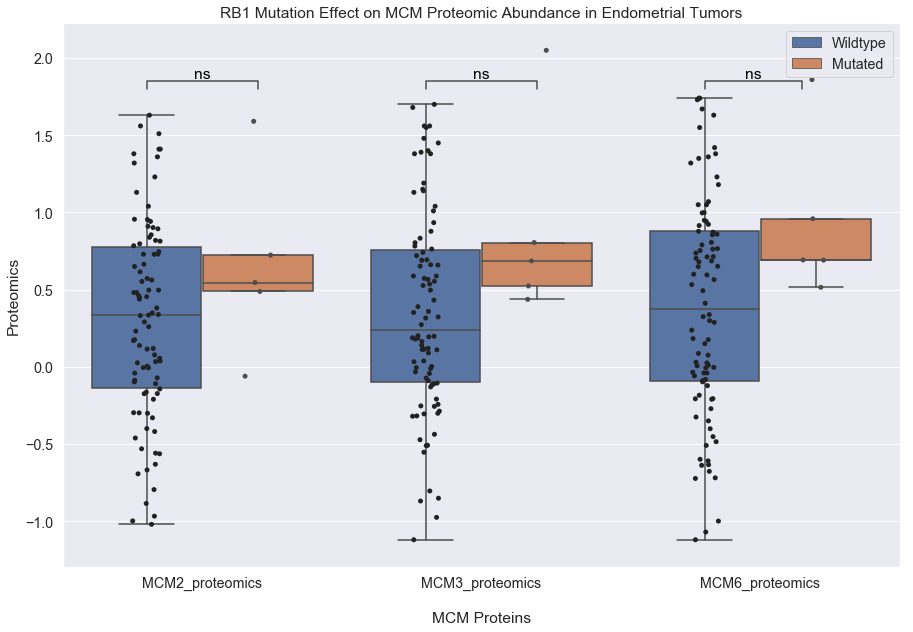

In [69]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='Name', y="value", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = binary_prot_melted, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Proteomic Abundance in Endometrial Tumors")
boxplot = sns.stripplot(x='Name', y="value", hue = 'RB1_mutation_status', data = binary_prot_melted, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Proteomics')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation= 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation('ns',-.2, .2, 1.8)
format_pval_annotation('ns',.8, 1.2, 1.8)
format_pval_annotation('ns',1.8, 2.15, 1.8)

plt.show()
plt.clf()
plt.close()

# Phosphopoteomics MCM

In [42]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = ['MCM2','MCM3','MCM6'])
flatten_phospho_and_mut = brain.reduce_multiindex(phos, flatten=True)

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['RB1_mutation_status'] = flatten_phospho_and_mut['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else('Normal' if x == 'Wildtype_Normal' else 'Mutated'))

# Step 3 - Format
mut_wt = flatten_phospho_and_mut.loc[flatten_phospho_and_mut['Sample_Status'] == 'Tumor'] # drop normal
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = mut_wt.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('RB1_mutation_status', axis = 1)

# keep dataframe formatted to graph with normal samples
phospho_normal = flatten_phospho_and_mut.drop(columns_to_drop, axis = 1) # includes normal samples 
only_phospho

Name,MCM2_phosphoproteomics_S108,MCM2_phosphoproteomics_S139,MCM2_phosphoproteomics_S170,MCM2_phosphoproteomics_S26,MCM2_phosphoproteomics_S27,MCM2_phosphoproteomics_S31,MCM2_phosphoproteomics_S40,MCM2_phosphoproteomics_S41,MCM2_phosphoproteomics_S53,MCM2_phosphoproteomics_T39,...,MCM3_phosphoproteomics_T758,MCM3_phosphoproteomics_T767,MCM3_phosphoproteomics_T770,MCM3_phosphoproteomics_Y204,MCM3_phosphoproteomics_Y750,MCM3_phosphoproteomics_Y753,MCM6_phosphoproteomics_S268,MCM6_phosphoproteomics_S271,MCM6_phosphoproteomics_S762,MCM6_phosphoproteomics_S802
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,NaN,0.75350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.68200,0.6400,NaN,NaN,0.22900,0.4790,NaN,NaN,-0.037200,NaN
S002,-0.4330,0.43600,NaN,NaN,0.79100,NaN,NaN,0.1970,NaN,NaN,...,0.45550,0.5520,0.486,NaN,0.24000,0.3480,NaN,NaN,0.973500,NaN
S003,NaN,-0.02880,NaN,NaN,-1.03000,NaN,NaN,NaN,NaN,NaN,...,-0.22000,-0.4020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S005,-0.4680,-0.05990,NaN,NaN,0.07490,NaN,NaN,-0.7540,0.1220,NaN,...,-0.13400,-0.3540,NaN,NaN,-0.35400,NaN,NaN,NaN,0.025600,NaN
S006,-0.0390,1.04000,NaN,NaN,0.55810,NaN,NaN,0.8360,0.1460,NaN,...,1.36500,0.6640,-0.042,NaN,1.06000,0.9800,NaN,NaN,2.070000,0.767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S099,0.5245,0.14700,NaN,NaN,0.30800,NaN,NaN,-0.9590,-1.3700,NaN,...,-0.06255,0.4320,NaN,NaN,0.07490,NaN,NaN,NaN,-0.187225,NaN
S100,0.1965,-0.05280,NaN,NaN,-0.35675,NaN,NaN,0.4945,0.1825,NaN,...,-0.12035,-0.0385,-0.364,NaN,-0.00601,-0.4020,NaN,NaN,0.876500,0.000
S101,-0.0864,0.34900,0.265,NaN,0.28200,NaN,NaN,NaN,NaN,NaN,...,0.30400,0.6725,NaN,NaN,0.26995,0.7150,NaN,NaN,1.239500,NaN


In [43]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'RB1_mutation_status', phos_col_list,verbose=True)
phos_pval_results

Doing t-test comparison for mutation status
MCM2_phosphoproteomics_S108 :  0.5935806514084911
MCM2_phosphoproteomics_S139 :  0.07419030694712286
MCM2_phosphoproteomics_S170 :  nan
MCM2_phosphoproteomics_S26 :  nan
MCM2_phosphoproteomics_S27 :  0.12534303762541835
MCM2_phosphoproteomics_S31 :  nan
MCM2_phosphoproteomics_S40 :  nan
MCM2_phosphoproteomics_S41 :  0.4257912597428418
MCM2_phosphoproteomics_S53 :  0.2804550801772304
MCM2_phosphoproteomics_T39 :  nan
MCM2_phosphoproteomics_T59 :  nan
MCM2_phosphoproteomics_Y137 :  nan
MCM2_phosphoproteomics_Y90 :  nan
MCM3_phosphoproteomics_S189 :  0.02663798668106569
MCM3_phosphoproteomics_S205 :  0.8716230971677732
MCM3_phosphoproteomics_S320 :  nan
MCM3_phosphoproteomics_S322 :  0.25863221123760965
MCM3_phosphoproteomics_S713 :  0.004154964830095312
MCM3_phosphoproteomics_S717 :  0.007045638988558833
MCM3_phosphoproteomics_S726 :  0.7031787181146978
MCM3_phosphoproteomics_S749 :  0.2196051958745101
MCM3_phosphoproteomics_S756 :  0.019276431

In [44]:
# Create data frame with all significant phospho sites in order to graph
#phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
phospho_list = list(only_phospho.columns)

phospho_df_RB1 = pd.melt(binary_phospho, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_RB1

,RB1_mutation_status,specific_phospho,phosphoproteomics
0,Wildtype,MCM2_S108,NaN
1,Wildtype,MCM2_S108,-0.433
2,Wildtype,MCM2_S108,NaN
3,Wildtype,MCM2_S108,-0.468
4,Wildtype,MCM2_S108,-0.039
...,...,...,...
3320,Wildtype,MCM6_S802,NaN
3321,Wildtype,MCM6_S802,0.000
3322,Wildtype,MCM6_S802,NaN
3323,Wildtype,MCM6_S802,NaN


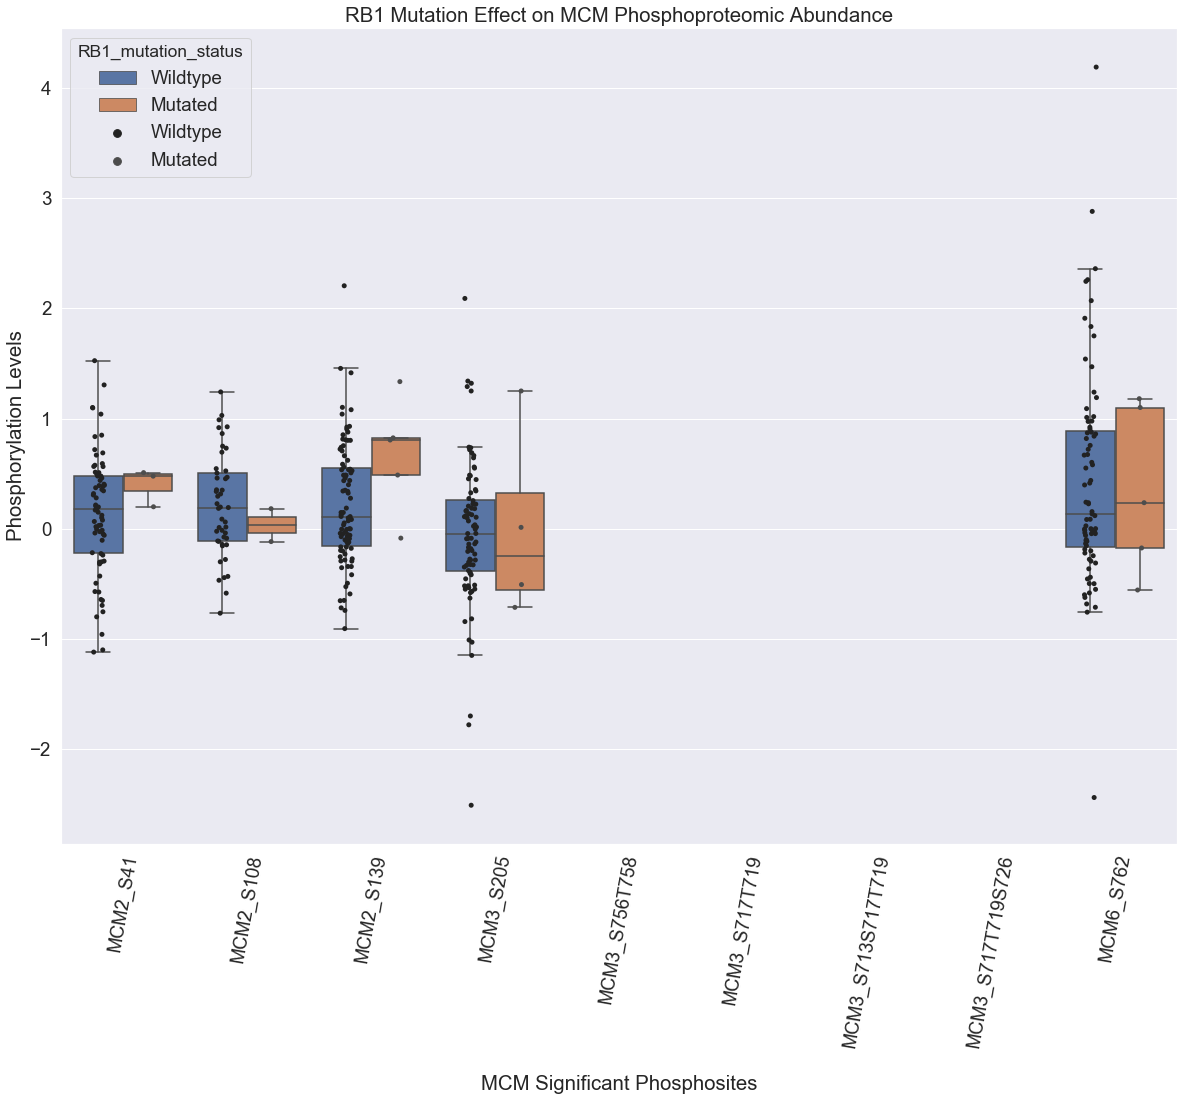

In [45]:
# Visualize 
plt.rcParams['figure.figsize']=(20,15)#size of plot
sns.set(font_scale = 1.7)

#plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                          hue_order = ['Wildtype', 'Mutated'],
                          order = ['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'],
                          data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_RB1, jitter = True, 
                           color = ".3",dodge = True, hue_order = ['Wildtype', 'Mutated'],
                           order=['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'])
boxplot.set(xlabel = "\nMCM Significant Phosphosites", ylabel = 'Phosphorylation Levels')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Normalize phopho

Data already is log transformed. To normalize Phosphoproteomics - Proteomics

MCM2

In [11]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM2')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM2_proteomics']]
mprot

Name,MCM2_proteomics
Sample_ID,
S001,0.6150
S002,0.9100
S003,-0.0715
S005,-0.5630
S006,1.4100
...,...
S099,0.4810
S100,0.2310
S101,0.7840


In [17]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM2')
flatten = brain.reduce_multiindex(phos, flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM2 = tumors.drop(columns_to_drop, axis = 1)
only_MCM2 = binary_MCM2.drop('RB1_mutation_status', axis = 1)

In [18]:
norm = pd.DataFrame()

for i, cols in only_MCM2.iteritems():
    norm[i] = cols - mprot['MCM2_proteomics']

MCM2_df = norm.join(binary_MCM2['RB1_mutation_status']) 

In [20]:
MCM2_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM2 phosphorylation")
MCM2_phos_pval_results = u.wrap_ttest(MCM2_df, 'RB1_mutation_status', MCM2_col_list)
MCM2_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM2 phosphorylation
No significant comparisons.


MCM3

In [24]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM3')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM3_proteomics']]
mprot

Name,MCM3_proteomics
Sample_ID,
S001,0.659
S002,0.934
S003,-0.301
S005,-0.256
S006,1.680
...,...
S099,0.566
S100,0.273
S101,0.763


In [23]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM3')
flatten = brain.reduce_multiindex(phos, flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM3 = tumors.drop(columns_to_drop, axis = 1)
only_MCM3 = binary_MCM3.drop('RB1_mutation_status', axis = 1)
binary_MCM3['RB1_mutation_status']
only_MCM3

Name,MCM3_phosphoproteomics_S189,MCM3_phosphoproteomics_S205,MCM3_phosphoproteomics_S320,MCM3_phosphoproteomics_S322,MCM3_phosphoproteomics_S713,MCM3_phosphoproteomics_S717,MCM3_phosphoproteomics_S726,MCM3_phosphoproteomics_S749,MCM3_phosphoproteomics_S756,MCM3_phosphoproteomics_T208,MCM3_phosphoproteomics_T209,MCM3_phosphoproteomics_T719,MCM3_phosphoproteomics_T758,MCM3_phosphoproteomics_T767,MCM3_phosphoproteomics_T770,MCM3_phosphoproteomics_Y204,MCM3_phosphoproteomics_Y750,MCM3_phosphoproteomics_Y753
Sample_ID,,,,,,,,,,,,,,,,,,
S001,NaN,-0.406,NaN,NaN,1.24000,0.4645,1.7600,NaN,0.53550,NaN,-0.9430,1.3600,0.68200,0.6400,NaN,NaN,0.22900,0.4790
S002,NaN,0.223,NaN,NaN,1.29000,0.8665,0.8505,NaN,0.58800,NaN,0.0704,0.7680,0.45550,0.5520,0.486,NaN,0.24000,0.3480
S003,NaN,0.274,NaN,NaN,-0.25400,-0.0848,NaN,NaN,-0.40200,NaN,NaN,-0.0639,-0.22000,-0.4020,NaN,NaN,NaN,NaN
S005,NaN,NaN,NaN,NaN,-0.60400,-0.2330,-1.0100,-0.3590,-0.11200,NaN,NaN,-0.2610,-0.13400,-0.3540,NaN,NaN,-0.35400,NaN
S006,-0.828,1.340,0.000,NaN,1.37000,1.7600,1.9750,NaN,1.40500,NaN,NaN,1.7600,1.36500,0.6640,-0.042,NaN,1.06000,0.9800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S099,NaN,NaN,NaN,NaN,0.14400,1.0300,-0.3770,0.2360,-0.20000,NaN,NaN,-0.3770,-0.06255,0.4320,NaN,NaN,0.07490,NaN
S100,0.985,1.250,-0.161,NaN,0.70800,0.1260,0.6047,NaN,-0.38085,NaN,NaN,0.0694,-0.12035,-0.0385,-0.364,NaN,-0.00601,-0.4020
S101,-0.196,0.689,NaN,NaN,0.60350,0.6205,0.9125,NaN,0.14520,NaN,NaN,0.3880,0.30400,0.6725,NaN,NaN,0.26995,0.7150


In [26]:
norm = pd.DataFrame()

for i, cols in only_MCM3.iteritems():
    norm[i] = cols - mprot['MCM3_proteomics']

MCM3_df = norm.join(binary_MCM3['RB1_mutation_status']) 
MCM3_df

,MCM3_phosphoproteomics_S189,MCM3_phosphoproteomics_S205,MCM3_phosphoproteomics_S320,MCM3_phosphoproteomics_S322,MCM3_phosphoproteomics_S713,MCM3_phosphoproteomics_S717,MCM3_phosphoproteomics_S726,MCM3_phosphoproteomics_S749,MCM3_phosphoproteomics_S756,MCM3_phosphoproteomics_T208,MCM3_phosphoproteomics_T209,MCM3_phosphoproteomics_T719,MCM3_phosphoproteomics_T758,MCM3_phosphoproteomics_T767,MCM3_phosphoproteomics_T770,MCM3_phosphoproteomics_Y204,MCM3_phosphoproteomics_Y750,MCM3_phosphoproteomics_Y753,RB1_mutation_status
Sample_ID,,,,,,,,,,,,,,,,,,,
S001,NaN,-1.065,NaN,NaN,0.58100,-0.1945,1.1010,NaN,-0.12350,NaN,-1.6020,0.7010,0.02300,-0.0190,NaN,NaN,-0.43000,-0.1800,Wildtype
S002,NaN,-0.711,NaN,NaN,0.35600,-0.0675,-0.0835,NaN,-0.34600,NaN,-0.8636,-0.1660,-0.47850,-0.3820,-0.448,NaN,-0.69400,-0.5860,Wildtype
S003,NaN,0.575,NaN,NaN,0.04700,0.2162,NaN,NaN,-0.10100,NaN,NaN,0.2371,0.08100,-0.1010,NaN,NaN,NaN,NaN,Wildtype
S005,NaN,NaN,NaN,NaN,-0.34800,0.0230,-0.7540,-0.1030,0.14400,NaN,NaN,-0.0050,0.12200,-0.0980,NaN,NaN,-0.09800,NaN,Wildtype
S006,-2.508,-0.340,-1.680,NaN,-0.31000,0.0800,0.2950,NaN,-0.27500,NaN,NaN,0.0800,-0.31500,-1.0160,-1.722,NaN,-0.62000,-0.7000,Wildtype
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S099,NaN,NaN,NaN,NaN,-0.42200,0.4640,-0.9430,-0.3300,-0.76600,NaN,NaN,-0.9430,-0.62855,-0.1340,NaN,NaN,-0.49110,NaN,Wildtype
S100,0.712,0.977,-0.434,NaN,0.43500,-0.1470,0.3317,NaN,-0.65385,NaN,NaN,-0.2036,-0.39335,-0.3115,-0.637,NaN,-0.27901,-0.6750,Wildtype
S101,-0.959,-0.074,NaN,NaN,-0.15950,-0.1425,0.1495,NaN,-0.61780,NaN,NaN,-0.3750,-0.45900,-0.0905,NaN,NaN,-0.49305,-0.0480,Wildtype


In [27]:
MCM3_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM3 phosphorylation")
MCM3_phos_pval_results = u.wrap_ttest(MCM3_df, 'RB1_mutation_status', MCM3_col_list)
MCM3_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM3 phosphorylation
1 significant comparisons!


,Comparison,P_Value
0,MCM3_phosphoproteomics_S713,0.00255


MCM6

In [28]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM6')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM6_proteomics']]
mprot

Name,MCM6_proteomics
Sample_ID,
S001,0.859
S002,1.070
S003,-0.210
S005,-0.350
S006,1.740
...,...
S099,0.686
S100,0.338
S101,0.923


In [29]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM6')
flatten = brain.reduce_multiindex(phos, flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM6 = tumors.drop(columns_to_drop, axis = 1)
only_MCM6 = binary_MCM6.drop('RB1_mutation_status', axis = 1)
binary_MCM6['RB1_mutation_status']
only_MCM6

Name,MCM6_phosphoproteomics_S268,MCM6_phosphoproteomics_S271,MCM6_phosphoproteomics_S762,MCM6_phosphoproteomics_S802
Sample_ID,,,,
S001,NaN,NaN,-0.037200,NaN
S002,NaN,NaN,0.973500,NaN
S003,NaN,NaN,NaN,NaN
S005,NaN,NaN,0.025600,NaN
S006,NaN,NaN,2.070000,0.767
...,...,...,...,...
S099,NaN,NaN,-0.187225,NaN
S100,NaN,NaN,0.876500,0.000
S101,NaN,NaN,1.239500,NaN


In [32]:
norm = pd.DataFrame()

for i, cols in only_MCM6.iteritems():
    norm[i] = cols - mprot['MCM6_proteomics']

MCM6_df = norm.join(binary_MCM6['RB1_mutation_status']) 
MCM6_df

,MCM6_phosphoproteomics_S268,MCM6_phosphoproteomics_S271,MCM6_phosphoproteomics_S762,MCM6_phosphoproteomics_S802,RB1_mutation_status
Sample_ID,,,,,
S001,NaN,NaN,-0.896200,NaN,Wildtype
S002,NaN,NaN,-0.096500,NaN,Wildtype
S003,NaN,NaN,NaN,NaN,Wildtype
S005,NaN,NaN,0.375600,NaN,Wildtype
S006,NaN,NaN,0.330000,-0.973,Wildtype
...,...,...,...,...,...
S099,NaN,NaN,-0.873225,NaN,Wildtype
S100,NaN,NaN,0.538500,-0.338,Wildtype
S101,NaN,NaN,0.316500,NaN,Wildtype


In [33]:
MCM6_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM6 phosphorylation")
MCM6_phos_pval_results = u.wrap_ttest(MCM6_df, 'RB1_mutation_status', MCM6_col_list, verbose=True)
MCM6_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM6 phosphorylation
MCM6_phosphoproteomics_S268 :  0.2171501580365825
MCM6_phosphoproteomics_S271 :  nan
MCM6_phosphoproteomics_S762 :  0.08735840056015247
MCM6_phosphoproteomics_S802 :  nan
No significant comparisons.


In [34]:
sig = list(MCM3_phos_pval_results['Comparison'])
mcm = MCM3_df[sig].join(binary_MCM3['RB1_mutation_status'])
d = {'MCM3_phosphoproteomics_S713': "MCM3_S713"}
mcm = mcm.rename(columns = d)
mcm

,MCM3_S713,RB1_mutation_status
Sample_ID,,
S001,0.58100,Wildtype
S002,0.35600,Wildtype
S003,0.04700,Wildtype
S005,-0.34800,Wildtype
S006,-0.31000,Wildtype
...,...,...
S099,-0.42200,Wildtype
S100,0.43500,Wildtype
S101,-0.15950,Wildtype


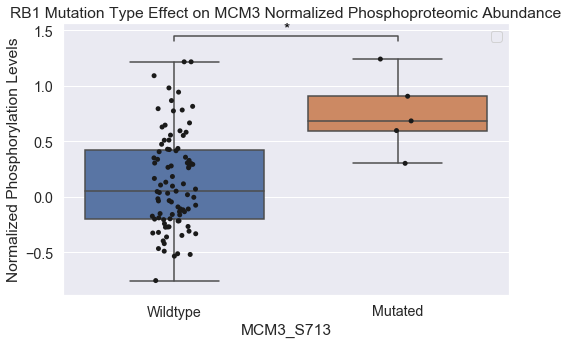

In [74]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(8,5) #size of plot
#sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='RB1_mutation_status', y="MCM3_S713",
                         order = ['Wildtype', 'Mutated'], data = mcm, showfliers = False)    
boxplot.set_title("RB1 Mutation Type Effect on MCM3 Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='RB1_mutation_status', y="MCM3_S713", data = mcm, jitter = True, 
                           color = ".1", order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "MCM3_S713", ylabel = 'Normalized Phosphorylation Levels')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation('*',0, 1, 1.4)

plt.show()
plt.clf()
plt.close()

In [ ]:
# create csv file
mcm = mcm.reset_index()
mcm['Gene'] = 'MCM6'
d = {'Sample_ID': "Sample", 
     'MCM6_S762': "Value",
    'RB1_mutation_status':"Status"}
#mcm = mcm.rename(columns = d)
#mcm.to_csv("MCM6.csv")

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
MCM = only_MCM2.join(only_MCM3)
MCM = MCM.join(only_MCM6)
sig_mcm = MCM[phospho_list]
norm_mcm236 = sig_mcm.join(binary_MCM6['RB1_mutation_status']) 
norm_mcm236

In [ ]:
phospho_df_MCM = pd.melt(norm_mcm236, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM


In [ ]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(15,8) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_MCM, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_MCM, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
d = {'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK': "MCM6_S762", 
     'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK': "MCM6_S762 2!",
     'MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK': "MCM3_S205",
     'MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT*EEEMPQVHTPK': "MCM3_S756T758",
     'MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK': "MCM3_S717T719",
     'MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK': "MCM3_S713S717T719",
     'MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*EDEEEKS*QEDQEQK': "MCM3_S717T719S726",
     'MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR': "MCM2_S108",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR': "MCM2_S139",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK': "MCM2_S139 2!",
     'MCM2_phosphoproteomics_S41_RTDALTSS*PGR': "MCM2_S41"}
sig2 = sig.rename(columns = d)
